# Library 

In [1]:
#데이터 로딩
import pandas as pd
import numpy as np
from glob import glob

#이미지데이터 로딩
from PIL import Image
import cv2
from tqdm import tqdm

#파일경로 설정
import os
import json

#기타
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [9]:
data_path = './go_traffic_file'

train_path = data_path + '/train'
test_path = data_path + '/test'

new_image_directory = data_path + '/new_images'
new_train_image_directory = new_image_directory + '/train'
new_test_image_directory = new_image_directory + '/test'

action_information = pd.read_csv(data_path + '/action_information.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

In [7]:
def make_new_dir(path):
    if os.path.isdir(path) == False:
        os.makedirs(path)

In [10]:
make_new_dir(new_image_directory)
make_new_dir(new_train_image_directory)
make_new_dir(new_test_image_directory)

In [50]:
action_information.head()

,action,Label
0,우측에서 좌측으로,0
1,전방정지,1
2,전후방 동시정지,2
3,좌우측방 동시정지,3
4,좌측에서 우측으로,4


# Check Sample Data 

In [32]:
train_folders = sorted(glob(
        train_path + '/*'), key = lambda x : int(x.split('/')[-1].replace('file_','')))
test_folders = sorted(glob(
        test_path + '/*'), key = lambda x : int(x.split('/')[-1].replace('file_','')))
train_folders[:5]

['./go_traffic_file/train/file_0',
 './go_traffic_file/train/file_1',
 './go_traffic_file/train/file_2',
 './go_traffic_file/train/file_3',
 './go_traffic_file/train/file_4']

In [47]:
train_folder = train_folders[0]

image_paths = sorted(glob(train_folder + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
json_path = glob(train_folder + '/*.json')[0]

(2160, 3840, 3)


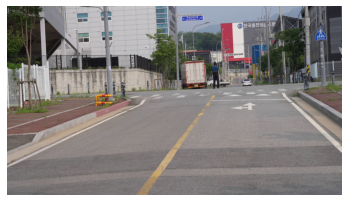

In [40]:
image_path = image_paths[0]
img = Image.open(image_path)
img_arr = np.array(img)
print(img_arr.shape)
plt.imshow(img_arr)
plt.axis('off')
plt.show()

In [48]:
js = json.load(open(json_path))

print('json keys : ', js.keys())
print('json action info : ', js.get('action'))
print('json sequence info : ', js.get('sequence').keys())
print('json info keys : ', js.get('info').keys())

json keys :  dict_keys(['action', 'sequence', 'info'])
json action info :  5
json sequence info :  dict_keys(['image_nums', '2d_pos', 'bounding_box', 'image_height', 'image_width'])
json info keys :  dict_keys(['actor_gender', 'actor_tall_range', 'actor_cloth', 's_height', 'lain_no', 's_dynamic', 's_weather', 's_season', 'direction'])


In [49]:
classes = pd.get_dummies(action_information[['Label']], columns = ['Label']).to_numpy()
classes

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

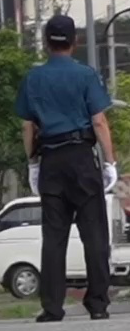

In [53]:
bounding_box = js.get('sequence').get('bounding_box')[0]
bounding_box = [float(x) for x in bounding_box]
image = Image.open(image_path)
image = image.crop(bounding_box)
image

# Save Data to Another Path 

In [69]:
train_directories = np.array(sorted(glob(
                                    train_path + '/*'), key = lambda x : int(x.split('/')[-1].split('_')[-1])))

for train_directory in tqdm(train_directories):
    file_name = train_directory.split('/')[-1]
    make_new_dir(new_train_image_directory + '/' + file_name)
    
    image_paths = sorted(glob(train_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
    json_path = glob(train_directory + '/*.json')[0]
    
    js = json.load(open(json_path))
    target = js.get('action')
    target = classes[target]
    bounding_boxes = js.get('sequence').get('bounding_box')
    bounding_boxes = [(float(a),float(b),float(c),float(d)) for a,b,c,d in bounding_boxes]
    
    for image_path, bounding_box in zip(image_paths, bounding_boxes):
        image = Image.open(image_path)
        image = image.crop(bounding_box)
        image = image.resize((224,224))
        image.save(new_train_image_directory + image_path.split('/train')[1])

    
    

100%|█████████████████████████████████████████| 142/142 [23:20<00:00,  9.86s/it]


In [70]:
test_directories = np.array(sorted(glob(
                                    test_path + '/*'), key = lambda x : int(x.split('/')[-1].split('_')[-1])))

for test_directory in tqdm(test_directories):
    file_name = test_directory.split('/')[-1]
    make_new_dir(new_test_image_directory + '/' + file_name)
    
    image_paths = sorted(glob(test_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
    json_path = glob(test_directory + '/*.json')[0]
    
    js = json.load(open(json_path))
    target = js.get('action')
    target = classes[target]
    bounding_boxes = js.get('sequence').get('bounding_box')
    bounding_boxes = [(float(a),float(b),float(c),float(d)) for a,b,c,d in bounding_boxes]
    
    for image_path, bounding_box in zip(image_paths, bounding_boxes):
        image = Image.open(image_path)
        image = image.crop(bounding_box)
        image = image.resize((224,224))
        image.save(new_test_image_directory + image_path.split('/test')[1])


100%|███████████████████████████████████████████| 45/45 [06:54<00:00,  9.20s/it]
